In [100]:
# !bash install.sh

In [1]:
%run prelude.py
%matplotlib inline

Could not load tabulate


# Pitfalls in Reading Graphs

> "Things are seldom what they seem" -- Buttercup / G&S Pinafore

We all look at line graphs every day, that visualize time series data.
There are a number of pitfalls when reading those graphs, that one should be aware of.

# Graphs contain lot's of data

It's easy to select a lot of values in a graph:

> 1 week @ 1M data contains already 10K values !

Here is a table:

```
duration      1M data       10s data      1s data
----------  ---------     ----------    ---------
1M                   1             6           60
1H                  60           360        3.600
1d               1.440         8.640       86.400
7d              10.080        60.480      604.800
30d             43.200       259.200    2.592.000
1y             525.600     3.153.600   31.536.000
```

Showing 10K values, or more values, on a single graph has multiple downsides. It can be ...

- Overwhelming the eye,
- Overwhelming the browser,
- slow to retrieve.

# Thee common Coping Strategies

In order not to get downed in data there are three strategies used in monitoring products:

1) Skipping Data (Prometheus)

2) Mean Aggregation (Circonus, Graphite, ... ?!)

3) Min/Max Aggregation (Circonus, Graphite, ...)

# Example Data: HTTP fetch durations against xkcd.com

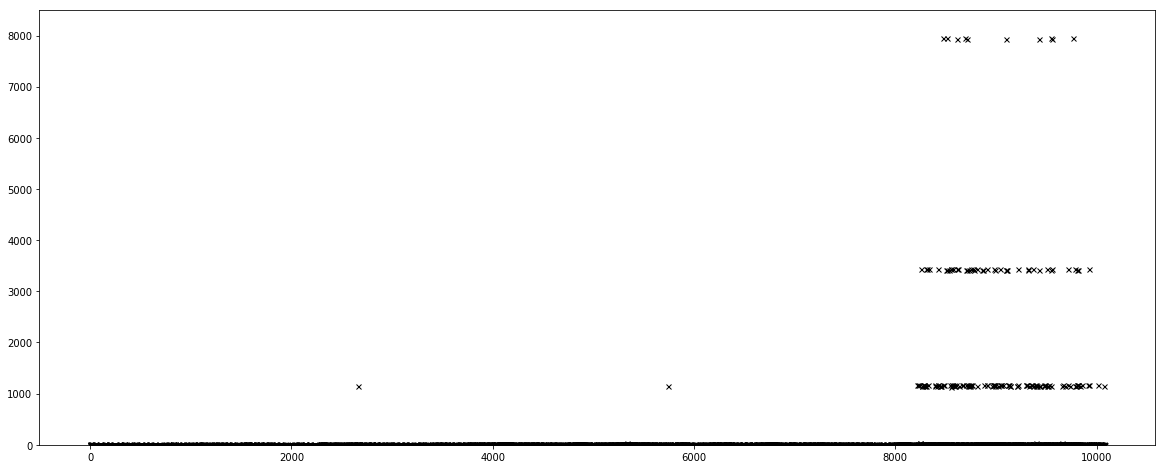

In [2]:
start = datetime(2019,1,1)
period = 60
count = 60 * 24 * 7

H("Raw Data")
P(count, "samples")

plt.figure(figsize=(20,8))
data = caql_plot("demo", """

find("duration","and(__check_uuid:8a6d6375-922f-4c29-a9f9-29e72e50d5af)")

""",  start, period, count,  "x", markersize=5, color="black")
plt.ylim(0, 8500)
plt.show()

In [3]:
def skip_plot(Y, skip):
    X = np.arange(0, len(Y), skip);
    Z = Y[::skip];
    H("{}M Skips".format(skip))
    P(len(Z), "samples");
    plt.plot(X, Z);

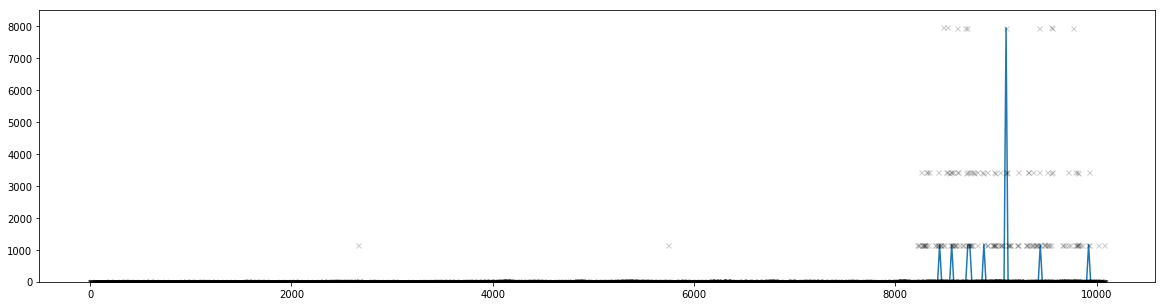

In [4]:
Y = np.array(data['duration'])
X = np.arange(0, len(Y))
plt.figure(figsize=(20,5))
plt.ylim(0, 8500)
skip_plot(Y, 20)
plt.plot(Y, "x", alpha=0.2, markersize=5, color="black")

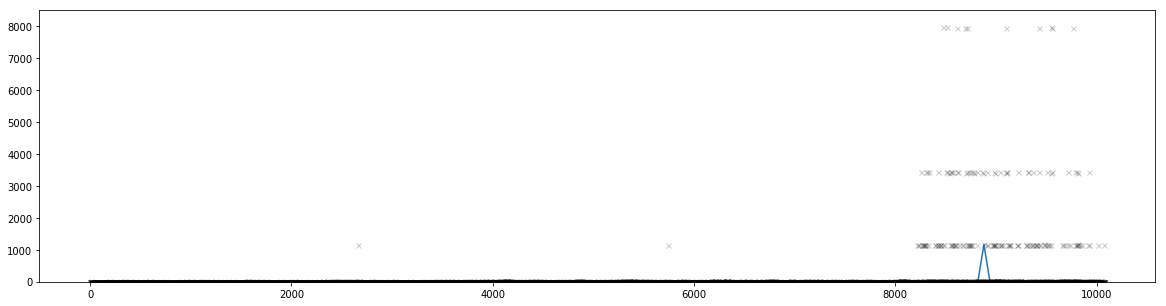

In [5]:
plt.figure(figsize=(20,5))
plt.ylim(0, 8500)
skip_plot(Y, 60)
plt.plot(Y, "x", alpha=0.2, markersize=5, color="black")

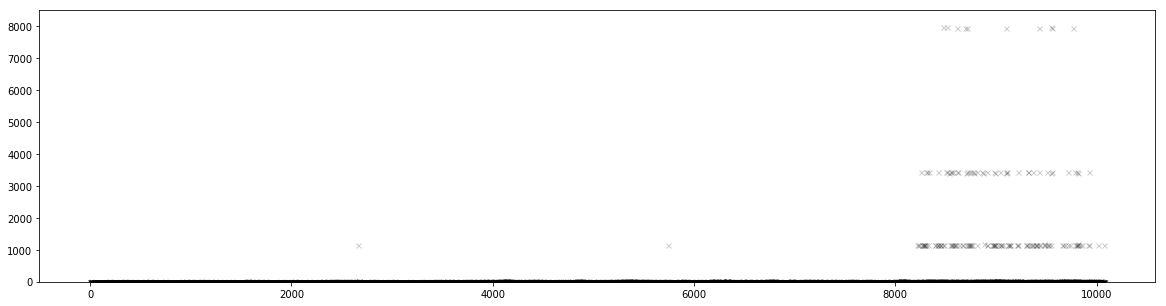

In [14]:
plt.figure(figsize=(20,5))
plt.ylim(0, 8500)
skip_plot(Y, 600)
plt.plot(Y, "x", alpha=0.2, markersize=5, color="black")

# Mean-Aggregation

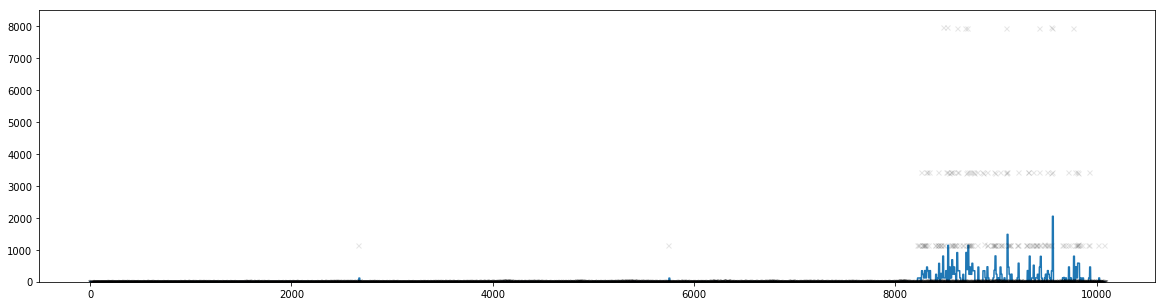

In [10]:
window = 10

H("{}M Mean Values".format(window))
P("{} samples".format(int(count/window)))
plt.figure(figsize=(20,5))
caql_plot("demo", """

find("duration","and(__check_uuid:8a6d6375-922f-4c29-a9f9-29e72e50d5af)")
| window:mean({}M)

""".format(window),  start, period, count)
plt.ylim(0, 8500)
plt.plot(Y, "x", alpha=0.1, markersize=5, color="black");
plt.show()

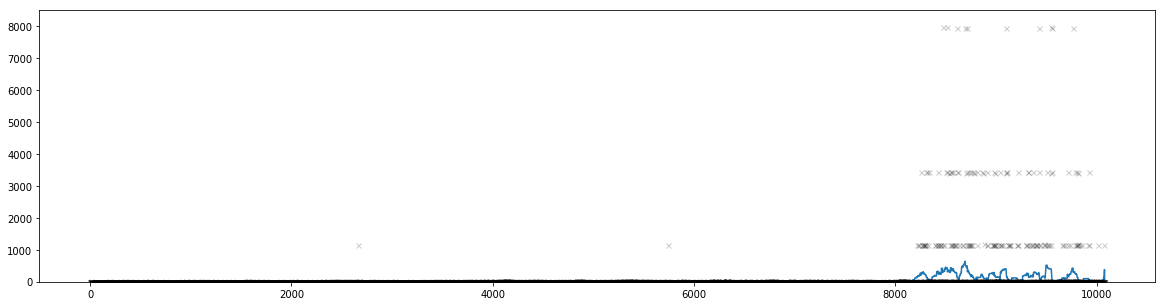

In [11]:
window = 60

H("{}M Mean Values".format(window))
P("{} samples".format(int(count/window)))
plt.figure(figsize=(20,5))
caql_plot("demo", """

hf:find("duration","and(__check_uuid:8a6d6375-922f-4c29-a9f9-29e72e50d5af)")
| hf:window:mean({}M)

""".format(window),  start, period, count)
plt.ylim(0, 8500)
plt.plot(Y, "x", alpha=0.2, markersize=5, color="black");
plt.show()

# Spike Erosion

You just whitnessed, spike erosion!

Large isolated spikes in the orginal data "erode" when zooming out of graphs:

- With skip aggregation they are randomly ignored
- With mean aggregation they get washed out

## Max Aggregation

If you are interested in the highest spikes, e.g. for:

- Max request rate over a week
- Max latency of a HTTP request (like here)

use max() instead of mean() to aggregate samples for visualization.

In [ ]:
window = 60

H("{}M Mean Values".format(window))
P("{} samples".format(int(count/window)))
plt.figure(figsize=(20,5))
caql_plot("demo", """

hf:find("duration","and(__check_uuid:8a6d6375-922f-4c29-a9f9-29e72e50d5af)")
| hf:window:max({}M)

""".format(window),  start, period, count)
plt.ylim(0, 8500)
plt.show()

# The Beam Effect

In [ ]:
H("Oscillating Data (simulated)")

Y = np.sin(np.linspace(0, 250*np.pi, num=1440))

P(len(Y), "samples")
plt.figure(figsize=(20,5))
plt.plot(Y, color="black");

In [ ]:
plt.figure(figsize=(20,5))
plt.ylim(-1, 1)
skip_plot(Y, 40)
plt.plot(Y, color="black", alpha=0.2)

In [ ]:
def mean_agg(Y, n):
    i = 0
    while(i < len(Y)):
        yield np.mean( Y[i : min(i+n, len(Y)-1)] )
        i = i + n

In [ ]:
window = 40
H("{}H Mean".format(window))
Z = list(mean_agg(Y, window))
X = np.arange(0, len(Y), window)
P(len(Z), "samples")
plt.figure(figsize=(20,5))
plt.plot(X,Z)
plt.ylim(-1,1);
plt.plot(Y, color="black", alpha=0.2)

# Discussion

* Applying skip-aggregation to oscillating data, can run into beam artifacts, that suggest a different period

* Applying mean-aggregation smoothes out the oscillation


# Conclusion

- No clear winner

- Usually mean-aggregation is least surprising

- Skip aggregation hides information in an uncontrolled way

- Need to be aware of "Spike Erosion" and "Beam" effects

- Good to have alternative aggregation methods available for e.g. max request rates.

> "You can't do capacity planning on average values"